In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

from matplotlib import rcParams
import matplotlib.pyplot as plt

# 1. Load datas

In [6]:
file_path = "../../Database/Ravi_Cancer_Cell_2022/scTumor_Tissue/#"
folders = ['UKF313', 'UKF315', 'UKF334', 'UKF357', 'UKF410']
adata_list = []
for folder in folders:
    adata = sc.read_10x_h5(file_path + folder + "_T_SCRNA/outs/filtered_feature_bc_matrix.h5")
    adata.obs['sample'] = folder
    adata.obs_names_make_unique()
    adata.var_names_make_unique()
    adata_list.append(adata)

/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_m

# 2. Filtering

In [7]:
for adata in adata_list:
    sc.pp.filter_cells(adata, min_genes = 30)

In [8]:
# Ribosomal genes for human
ribo_url = 'http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt'
ribo_genes = pd.read_table(ribo_url, skiprows = 2, header = None)

del ribo_url

In [9]:
# Calculate QC metrics
for adata in adata_list:
    adata.var['mito'] = adata.var_names.str.startswith('MT-')   # 'mt-' for mouse, 'MT-' for human  # mitochondrial genes boolean
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)  # ribosomal genes boolean
    
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True, qc_vars=['mito', 'ribo'])    # calculate qc metrics

    # remove useless vars
    adata.obs.drop(columns=['total_counts_mito', 'total_counts_ribo'], inplace=True)
    adata.var.drop(columns=['mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'], inplace=True)

adata_list
del ribo_genes

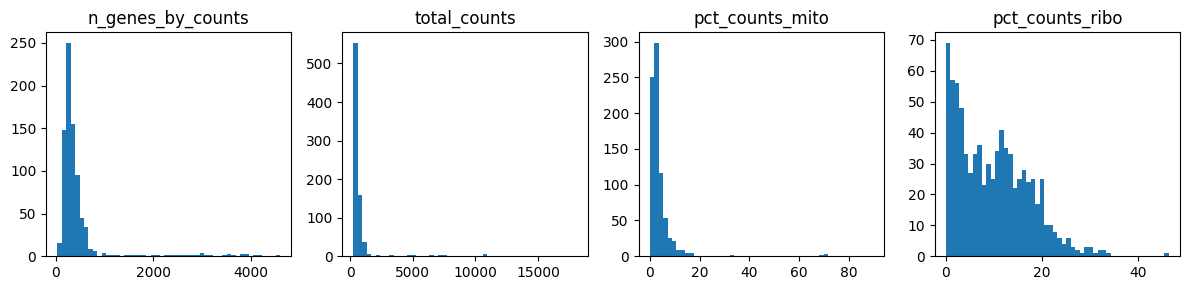

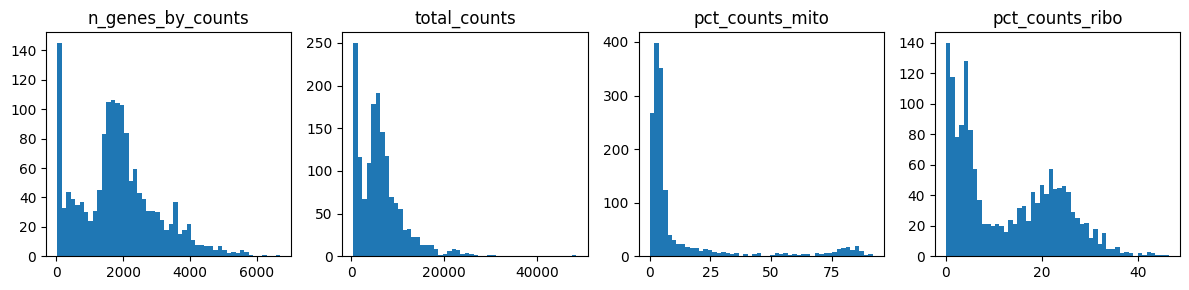

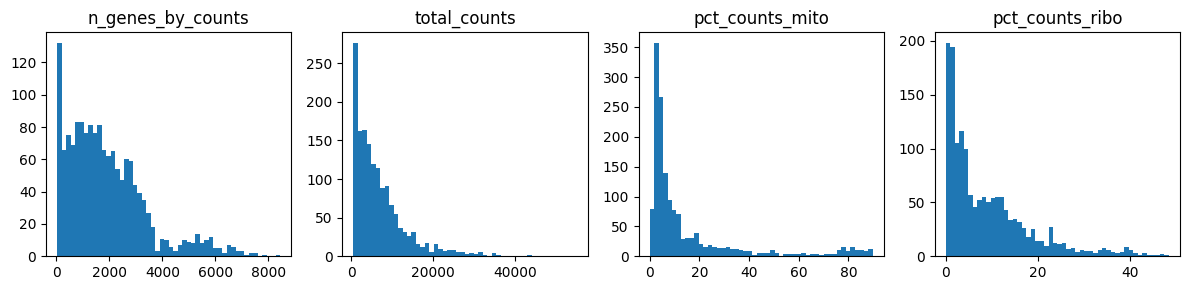

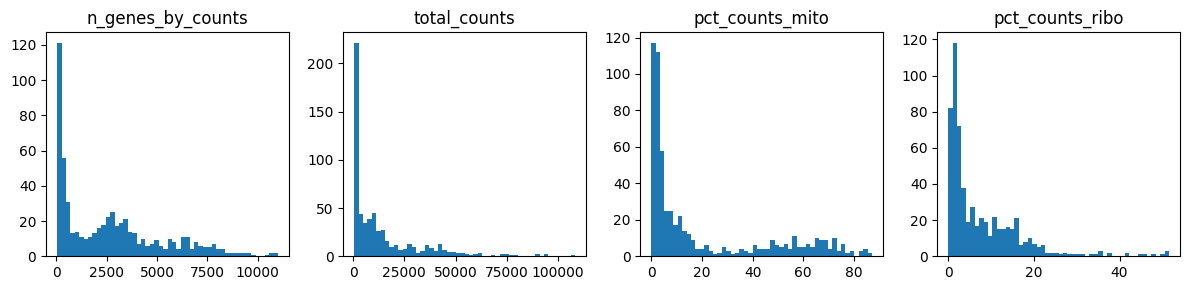

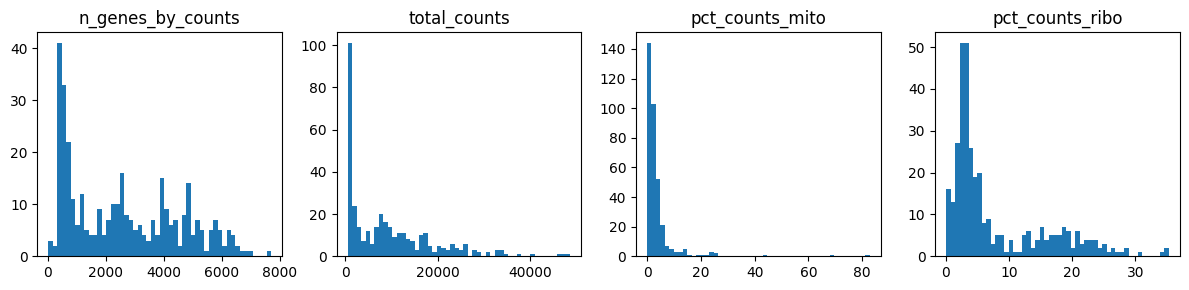

In [10]:
# Histogram of the cell quality
for adata in adata_list:
    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (12, 3))
    n_bins = 50
    ax[0].hist(adata.obs.n_genes_by_counts, bins = n_bins)
    ax[0].set_title("n_genes_by_counts")
    
    ax[1].hist(adata.obs.total_counts, bins = n_bins)
    ax[1].set_title("total_counts")
    
    ax[2].hist(adata.obs.pct_counts_mito, bins = n_bins)
    ax[2].set_title("pct_counts_mito")
    
    ax[3].hist(adata.obs.pct_counts_ribo, bins = n_bins)
    ax[3].set_title("pct_counts_ribo")
    

    plt.tight_layout()
    plt.show
    del fig, ax, n_bins

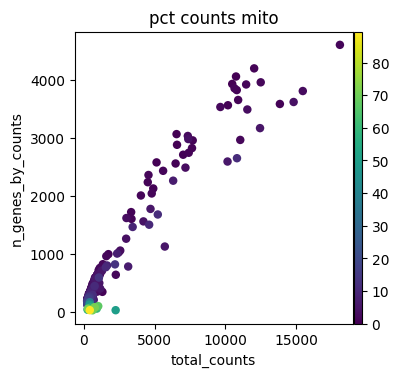

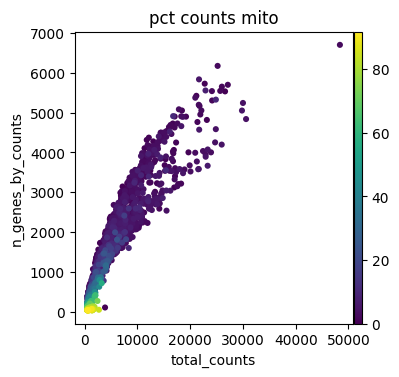

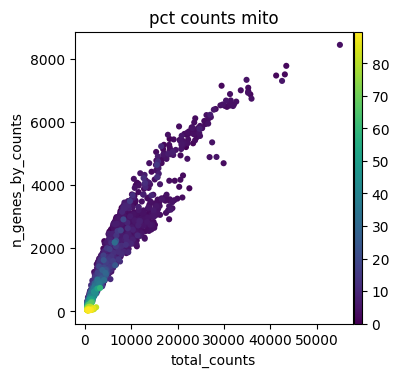

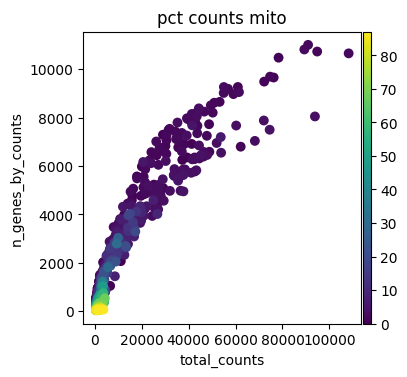

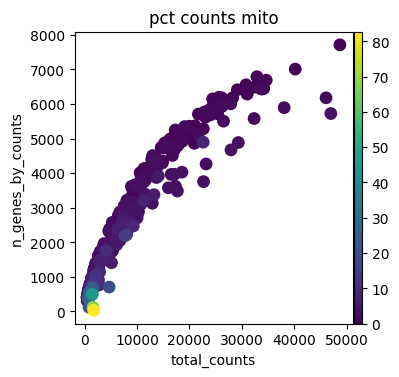

In [11]:
# Scatter plot of the cell quality
rcParams['figure.figsize'] = 4, 4 # width, height

for adata in adata_list:
    sc.pl.scatter(
        adata,
        x = 'total_counts',
        y = 'n_genes_by_counts',
        color = 'pct_counts_mito',
    )

In [12]:
# Filter the data
for i in range(len(adata_list)):
    cutoff_top = np.quantile(adata_list[i].obs.n_genes_by_counts.values, .95)
    adata_list[i] = adata_list[i][adata_list[i].obs.n_genes_by_counts < cutoff_top]
    
    cutoff_top = np.quantile(adata_list[i].obs.total_counts.values, .95)
    adata_list[i] = adata_list[i][adata_list[i].obs.total_counts < cutoff_top]
    
    cutoff_top = np.quantile(adata_list[i].obs.pct_counts_mito.values, .90)
    adata_list[i] = adata_list[i][adata_list[i].obs.pct_counts_mito < cutoff_top]

adata_list
del cutoff_top, i

In [13]:
# additional fine-tuning cutoff for some samples
adata_list[1] = adata_list[1][adata_list[1].obs.pct_counts_mito < 10]
adata_list[2] = adata_list[2][adata_list[2].obs.pct_counts_mito < 20]
adata_list[3] = adata_list[3][adata_list[3].obs.pct_counts_mito < 20]

adata_list[0] = adata_list[0][adata_list[0].obs.pct_counts_ribo < 30]
adata_list[1] = adata_list[1][adata_list[1].obs.pct_counts_ribo < 40]
adata_list[2] = adata_list[2][adata_list[2].obs.pct_counts_ribo < 40]
adata_list[3] = adata_list[3][adata_list[3].obs.pct_counts_ribo < 30]
adata_list[4] = adata_list[4][adata_list[4].obs.pct_counts_ribo < 30]

adata_list[3] = adata_list[3][adata_list[3].obs.total_counts > 1000]
adata_list[4] = adata_list[4][adata_list[4].obs.total_counts > 1000]

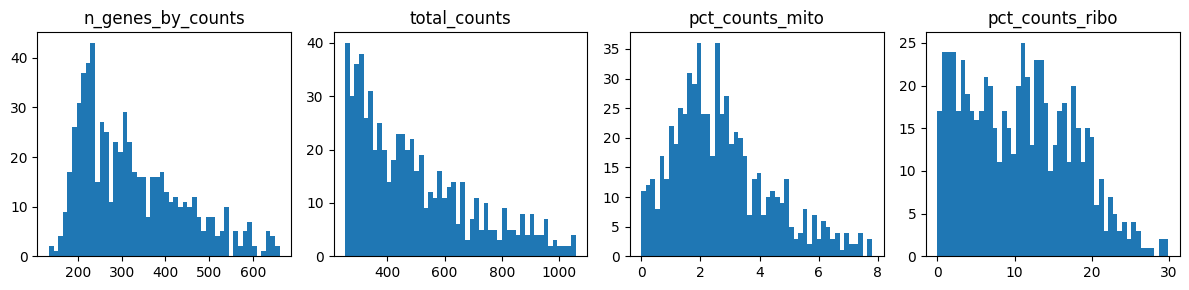

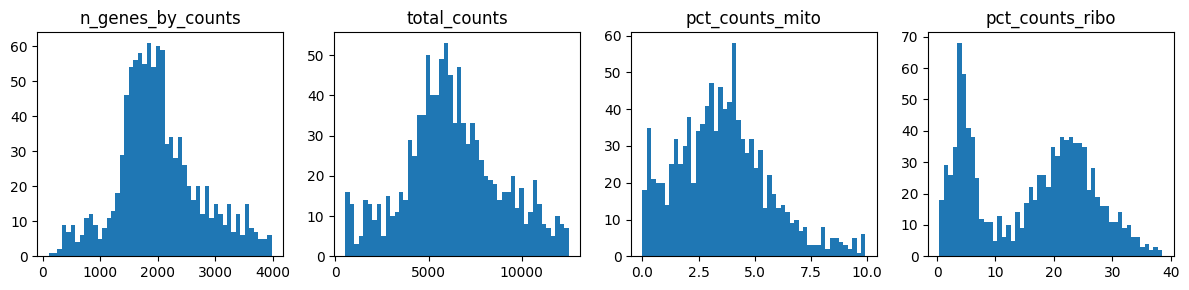

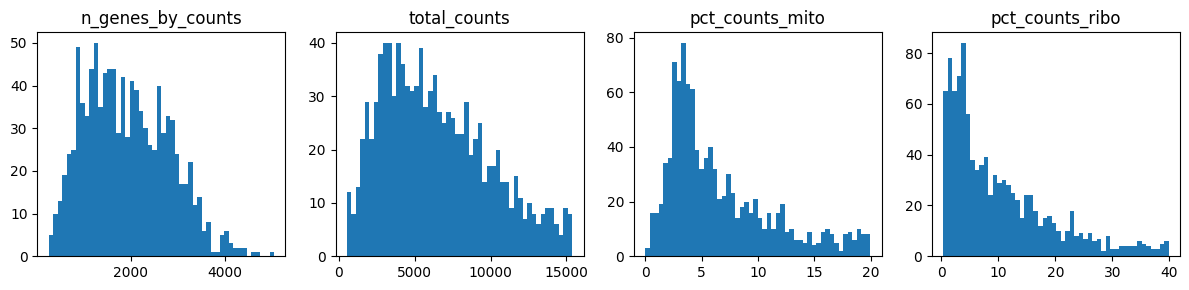

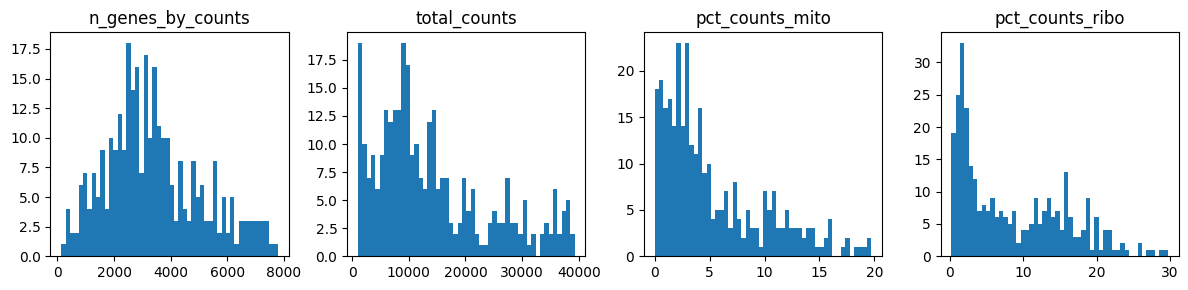

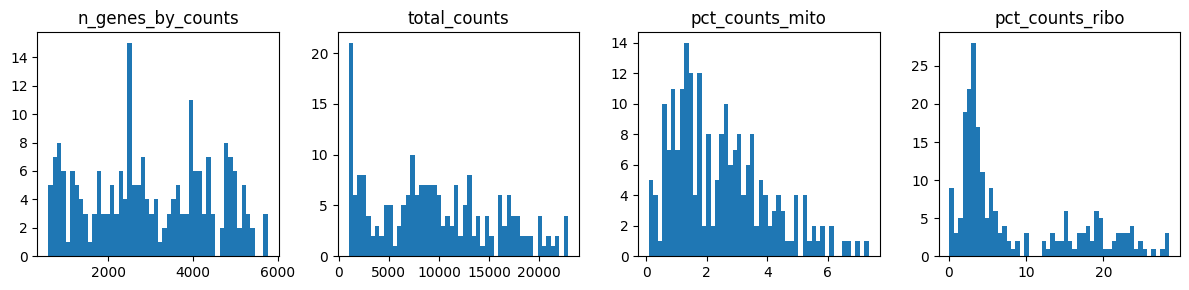

In [14]:
# Histogram of the cell quality
for adata in adata_list:
    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (12, 3))
    n_bins = 50
    ax[0].hist(adata.obs.n_genes_by_counts, bins = n_bins)
    ax[0].set_title("n_genes_by_counts")
    
    ax[1].hist(adata.obs.total_counts, bins = n_bins)
    ax[1].set_title("total_counts")
    
    ax[2].hist(adata.obs.pct_counts_mito, bins = n_bins)
    ax[2].set_title("pct_counts_mito")
    
    ax[3].hist(adata.obs.pct_counts_ribo, bins = n_bins)
    ax[3].set_title("pct_counts_ribo")
    

    plt.tight_layout()
    plt.show
    del fig, ax, n_bins

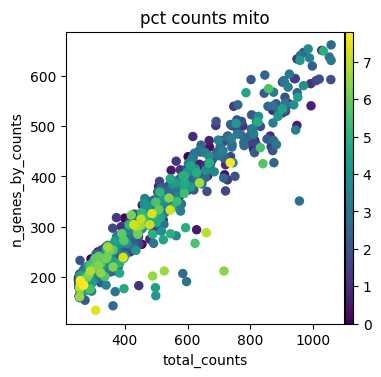

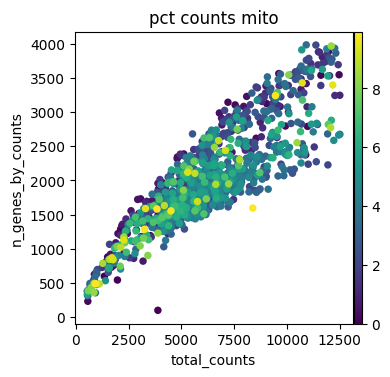

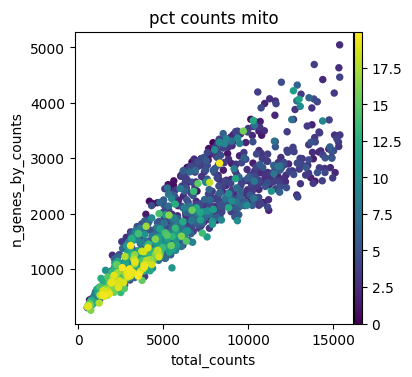

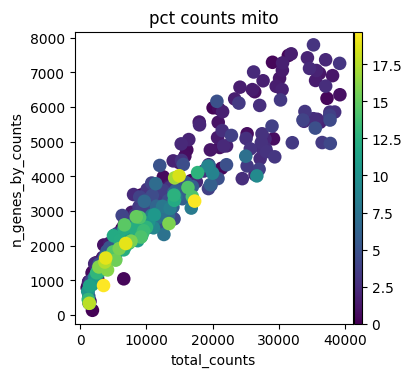

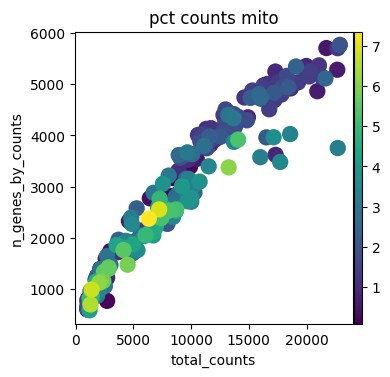

In [15]:
# Scatter plot of the cell quality
rcParams['figure.figsize'] = 4, 4 # width, height

for adata in adata_list:
    sc.pl.scatter(
        adata,
        x = 'total_counts',
        y = 'n_genes_by_counts',
        color = 'pct_counts_mito',
    )

In [ ]:
import scrublet as scr
for i, adata in enumerate(adata_list):
    try:
        # Scrublet 객체 생성
        scrub = scr.Scrublet(adata.X)
        
        doublet_scores, predicted_doublets = scrub.scrub_doublets()
        
        adata.obs['doublet_scores'] = doublet_scores
        adata.obs['predicted_doublets'] = predicted_doublets
        
        print(f"Processed adata {i + 1}/{len(adata_list)} successfully.")
        scrub.plot_histogram()
    except Exception as e:
        print(f"Error in processing adata {i + 1}/{len(adata_list)}: {e}")
        # adata.obs의 doublet_scores와 predicted_doublets에 모두 NA를 설정
        adata.obs['doublet_scores'] = pd.Series([np.nan] * adata.shape[0])
        adata.obs['predicted_doublets'] = pd.Series([np.nan] * adata.shape[0])
        continue

del scrub, doublet_scores, predicted_doublets

In [16]:
adata_list

[View of AnnData object with n_obs × n_vars = 649 × 33538
     obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'
     var: 'gene_ids', 'feature_types', 'genome',
 View of AnnData object with n_obs × n_vars = 1033 × 33538
     obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'
     var: 'gene_ids', 'feature_types', 'genome',
 View of AnnData object with n_obs × n_vars = 1047 × 33538
     obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'
     var: 'gene_ids', 'feature_types', 'genome',
 View of AnnData object with n_obs × n_vars = 315 × 33538
     obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'
     var: 'gene_ids', 'feature_types', 'genome',
 View of AnnData object with n_obs × n_vars = 217 × 33538
     obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_

In [17]:
adata = sc.concat(adata_list, merge = 'same')
adata.obs.drop(columns=['n_genes_by_counts', 'predicted_doublets', 'doublet_scores'], inplace=True)

# adata.obs_names_make_unique()

KeyError: "['predicted_doublets', 'doublet_scores'] not found in axis"

In [18]:
adata

AnnData object with n_obs × n_vars = 3261 × 33538
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'genome'

In [19]:
# filter out genes expressed in less than 3 cells
sc.pp.filter_genes(adata, min_cells=3) 

# preserve the raw data
adata.layers['counts'] = adata.X.copy() # scVI use this data

In [20]:
# Save the merged data
adata.write_h5ad("../data/adata_merged.h5ad")